In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
OMP_NUM_THREADS=1

In [2]:

from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report,auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


### READ THE DATA

In [3]:

data = load_wine()
X = data.data      # Feature matrix
y = data.target    # Target variable

feature_names = data.feature_names

X_fr=pd.DataFrame(X,columns=data.feature_names)
X_fr.rename(columns={'od280/od315_of_diluted_wines': 'od280-315'}, inplace=True)
y_fr=pd.DataFrame(y)
print(type(X_fr))
print(X_fr.shape)
print(X_fr.head())


<class 'pandas.core.frame.DataFrame'>
(178, 13)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280-315  

### Split into training and testing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_fr, y_fr,test_size=0.33, random_state=42, stratify=y)

# This is needed for package that needs a Series as input.
y_trainorig=y_train
# THIS IS NEEDED FOR THE FIT FUNCTION OF THE ESTIMATORS. THE SERIES NEEDS TO BE CONVERTED TO 
#A 1-D ARRAY.
print(type(X_train))
y_train= y_train.to_numpy()
y_train=y_train.ravel()
print(type(y_train))
print(y_train.shape)
y_test= y_test.to_numpy()
y_test=y_test.ravel()

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(119,)


### Scale the data

In [5]:

from sklearn.preprocessing import StandardScaler

ss = StandardScaler() # Standardization

X_sctrain = ss.fit_transform(X_train)
print(type(X_sctrain))
X_df=pd.DataFrame(X_sctrain,columns=feature_names)
sd=pd.DataFrame(X_sctrain)

X_sctest = ss.fit_transform(X_test)



<class 'numpy.ndarray'>
2.304984856639071


### Clustering

In [ ]:

OMP_NUM_THREADS=1
model = KMeans(n_clusters=3,n_init=20, random_state=40)
model.fit(X_sctrain)

# Check the cluster labels found by k-means
clusters = model.labels_

# Optionally, compare with the actual labels to evaluate the clustering (though in real clustering tasks, this wouldn't be possible)
pd.crosstab(y_train, clusters)
print(f"The actual label of sample 41 is: {y_train[34]}")
print(f"The predicted label of sample 41 is: {clusters[34]}")


### PCA

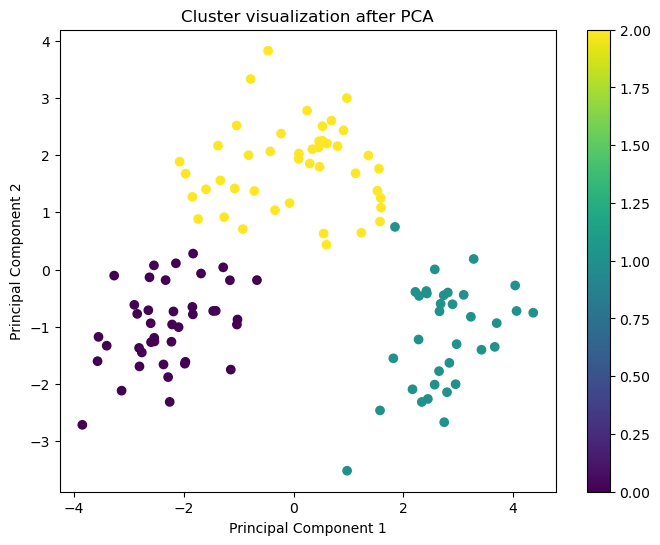

In [8]:


OMP_NUM_THREADS=1

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sctrain)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', label=data.target_names)
plt.title('Cluster visualization after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()



### Find class correspondence 

In [8]:
# THIS IS AN IMPORTANT STEP. We need to find what is the mapping between the original class labels and
# the ones assigned by pandas

import pandas as pd

# y would be your actual class labels
# clusters would be the labels assigned by KMeans

# Create a DataFrame for easier handling
df = pd.DataFrame({'True Label': y_train, 'Cluster Label': clusters})

# Use crosstab to see the relationship between true labels and cluster assignments
crosstab_result = pd.crosstab(df['True Label'], df['Cluster Label'])
print(crosstab_result)



Cluster Label   0   1   2
True Label               
0              39   0   0
1               2   2  44
2               0  32   0
True Label
0    39
1     2
2     0
Name: 0, dtype: int64


### Map to true classes and recompute crosstab

In [16]:
# Define the mapping based on your findings
cluster_to_class_map = {0: 0, 1: 2, 2: 1}

# Apply the mapping to the cluster labels to translate them to the actual class labels
translated_labels = [cluster_to_class_map[cluster] for cluster in clusters]

# Now you can use these translated labels to compare with the actual labels

# Create a DataFrame for easier handling
df = pd.DataFrame({'True Label': y_train, 'Cluster Label': translated_labels})

# Use crosstab to see the relationship between true labels and cluster assignments
crosstab_result = pd.crosstab(df['True Label'], df['Cluster Label'])
print(crosstab_result)


misclassified_indices = []
for idx, true_label in enumerate(y_train):
    cluster_label = translated_labels[idx]
    if true_label != cluster_label:
        misclassified_indices.append(idx)

print("Misclassified samples indices:", misclassified_indices)





Cluster Label   0   1   2
True Label               
0              39   0   0
1               2  44   2
2               0   0  32
Misclassified samples indices: [37, 63, 81, 111]


C:\Users\theom\anaconda3\envs\mysk\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


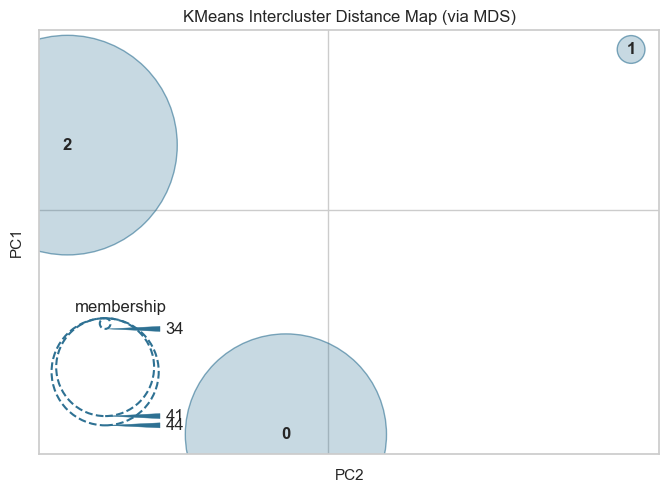

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [19]:
from yellowbrick.cluster import InterclusterDistance
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()    